<a href="https://colab.research.google.com/github/aderdouri/ActuarialThesis/blob/master/Notebooks/Classifiers/myXGBoostClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification XGBoost

## Cloner la branche contenant le dataset le code qui va avec.

In [ ]:
!rm -rf ActuarialThesis
!git clone https://github.com/aderdouri/ActuarialThesis.git
%ls -ltr ActuarialThesis

Cloning into 'ActuarialThesis'...
remote: Enumerating objects: 922, done.
remote: Counting objects: 100% (205/205), done.
remote: Compressing objects: 100% (119/119), done.
remote: Total 922 (delta 97), reused 182 (delta 85), pack-reused 717
Receiving objects: 100% (922/922), 128.07 MiB | 16.37 MiB/s, done.
Resolving deltas: 100% (387/387), done.
total 484
drwxr-xr-x 2 root root   4096 Oct 29 15:15 AllstateClaimPredictionChallenge/
drwxr-xr-x 2 root root   4096 Oct 29 15:15 AllstateClaimsSeverity/
drwxr-xr-x 2 root root   4096 Oct 29 15:15 Data/
drwxr-xr-x 2 root root   4096 Oct 29 15:15 EMTboost/
drwxr-xr-x 2 root root   4096 Oct 29 15:15 FrenchMotorThirdPartyLiabilityClaims/
drwxr-xr-x 2 root root   4096 Oct 29 15:15 Models/
drwxr-xr-x 2 root root   4096 Oct 29 15:15 Notebooks/
drwxr-xr-x 2 root root   4096 Oct 29 15:15 Plots/
-rw-r--r-- 1 root root     54 Oct 29 15:15 README.md
drwxr-xr-x 2 root root   4096 Oct 29 15:15 src/
-rw-r--r-- 1 root root 454571 Oct 29 15:15 myCatBoostClass

In [ ]:
!mkdir ActuarialThesis/plots_clf
!ls -ltr ActuarialThesis/plots_clf

total 0


In [ ]:
# Ajouter le répértoire src
import sys
sys.path.insert(0,'./ActuarialThesis/src/')

In [ ]:
import installHelper

In [ ]:
print(list(dir(installHelper)))

['__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'installALL', 'subprocess', 'sys']


In [ ]:
!ls -ltr

total 8
drwxr-xr-x  1 root root 4096 Oct 26 13:24 sample_data
drwxr-xr-x 13 root root 4096 Oct 29 15:15 ActuarialThesis


# Installer les packages nécéssaires

In [ ]:
%time installHelper.installALL()

CPU times: user 132 ms, sys: 28.3 ms, total: 160 ms
Wall time: 42 s


In [ ]:
# On doit trouver tous les packages mentionés dans le grep
!pip list -v | grep -e catboost -e 'imbalanced-learn' -e 'optuna' -e 'catboost' -e 'lime' -e 'shap'

catboost                         1.2.2                 /usr/local/lib/python3.10/dist-packages pip
imbalanced-learn                 0.10.1                /usr/local/lib/python3.10/dist-packages pip
lime                             0.2.0.1               /usr/local/lib/python3.10/dist-packages pip
optuna                           3.4.0                 /usr/local/lib/python3.10/dist-packages pip
shap                             0.43.0                /usr/local/lib/python3.10/dist-packages pip
shapely                          2.0.2                 /usr/local/lib/python3.10/dist-packages pip


# Importer les packages nécéssaires

In [ ]:
from helper import *

In [ ]:
# Appliquer le theme par défaut
sns.set_theme()

# Partir du dataset déja encodé.

In [ ]:
# Partir du dataset déja encodé.
df = pd.read_csv('ActuarialThesis/Data/encodedBASEAUTO.csv')
df.head()

,ACV,SEX,STATUT,AGECOND,K8000,RM,CAR,USAGE_Prive,USAGE_PriveTrajet,USAGE_Professionnel,...,SEGM_H,SEGM_M1,SEGM_M2,GARAGE_ClosCollectif,GARAGE_GarageAutre,GARAGE_IndividuelClos,CSP_CSP_50,CSP_CSP_60,CSP_CSP_AUTRE,CHARGE
0,1.134929,1,1,-0.457663,0,-0.094064,0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1,1.134929,1,0,1.101165,0,-0.817279,0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2,1.134929,1,1,-1.813166,0,1.507343,0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,1.134929,1,0,0.626739,0,-0.817279,0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,1.134929,1,0,-1.203190,0,1.507343,0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


In [ ]:
# Separation de la variable target du dataset
Y = df['CHARGE']
X = df.drop('CHARGE', axis=1)

# Target variable mapping

In [ ]:
# Ici nous allons considérer le problème comme un problème de classification
# Class 0 si la CHARGE==0 sinon Class 1.
y = Y.map(lambda val: 0 if val<=0 else 1)

In [ ]:
y.unique()

array([0, 1])

# Modeling

## 3.1 Handling the imbalances

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [ ]:
X_train.shape, X_val.shape, X_test.shape

((6297, 67), (2099, 67), (2100, 67))

In [ ]:
y_train.shape, y_val.shape, y_test.shape

((6297,), (2099,), (2100,))

In [ ]:
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weight = dict(zip(classes, weights))

scale_pos_weight = sum(class_weight.values()) / sum(class_weight.keys())
class_weight, scale_pos_weight

({0: 0.5764372024899305, 1: 3.7706586826347306}, 4.347095885124661)

In [ ]:
class_weight, scale_pos_weight

({0: 0.5764372024899305, 1: 3.7706586826347306}, 4.347095885124661)

In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=3, timeout=600)

[I 2023-10-28 22:47:41,270] A new study created in memory with name: no-name-80c9e89b-681b-4da9-bdd8-86dd3876a8f7
[I 2023-10-28 22:47:50,378] Trial 0 finished with value: 0.6646397594941936 and parameters: {'scale_pos_weight': 4.347095885124661, 'tree_method': 'exact', 'booster': 'gbtree', 'lambda': 4.221318972054662e-06, 'alpha': 2.054930442185539e-06, 'max_depth': 8, 'eta': 3.83684094576388e-08, 'gamma': 0.024766016917219878, 'grow_policy': 'depthwise'}. Best is trial 0 with value: 0.6646397594941936.
[I 2023-10-28 22:47:53,200] Trial 1 finished with value: 0.6730125802041439 and parameters: {'scale_pos_weight': 4.347095885124661, 'tree_method': 'exact', 'booster': 'gbtree', 'lambda': 0.00016951378391628433, 'alpha': 4.6693159336215535e-08, 'max_depth': 9, 'eta': 4.46402537354107e-05, 'gamma': 1.1167022381084885e-06, 'grow_policy': 'depthwise'}. Best is trial 1 with value: 0.6730125802041439.
[I 2023-10-28 22:48:01,206] Trial 2 finished with value: 0.7114009660144429 and parameters: 

In [ ]:
import xgboost as xgb
from sklearn.metrics import average_precision_score
from optuna.integration import XGBoostPruningCallback

def objective(trial):
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dvalid = xgb.DMatrix(X_val, label=y_val)

    param = {
        "verbosity": 0,
        "objective": "binary:logistic",
        "eval_metric": "auc",
        "class_weight": trial.suggest_categorical("class_weights", [class_weight, class_weight]),
        "scale_pos_weight": trial.suggest_float("scale_pos_weight", scale_pos_weight, scale_pos_weight),
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
    }

    if param["booster"] == "gbtree" or param["booster"] == "dart":
        param["max_depth"] = trial.suggest_int("max_depth", 1, 9)
        param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
        param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])
    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
        param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)

    # Add a callback for pruning.
    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, "validation-auc")
    bst = xgb.train(param,
                    dtrain,
                    evals=[(dvalid, "validation")],
                    callbacks=[pruning_callback])
    preds = bst.predict(dvalid)
    pred_labels = np.rint(preds)
    accuracy = accuracy_score(y_val, pred_labels)
    return accuracy

In [ ]:
study = optuna.create_study(
    pruner=optuna.pruners.MedianPruner(n_warmup_steps=5), direction="maximize")
study.optimize(objective, n_trials=10)
print(study.best_trial)

[I 2023-10-29 15:52:42,528] A new study created in memory with name: no-name-36618955-7ae8-4a49-8791-68c6d57aedd0


[0]	validation-auc:0.70022
[1]	validation-auc:0.71171
[2]	validation-auc:0.71034
[3]	validation-auc:0.71319
[4]	validation-auc:0.71441
[5]	validation-auc:0.71427
[6]	validation-auc:0.71707
[7]	validation-auc:0.71838
[8]	validation-auc:0.72075
[9]	validation-auc:0.72049


/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:524: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains {0: 0.5764372024899305, 1: 3.7706586826347306} which is of type dict.

[I 2023-10-29 15:52:42,623] Trial 0 finished with value: 0.6788947117675084 and parameters: {'class_weights': {0: 0.5764372024899305, 1: 3.7706586826347306}, 'scale_pos_weight': 4.347095885124661, 'booster': 'dart', 'lambda': 0.044725871553871095, 'alpha': 0.14854796468692602, 'max_depth': 3, 'eta': 0.3749947940342146, 'gamma': 3.0496187901303513e-08, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 1.1404044097212259e-08, 'skip_drop': 6.044689217925561e-08}. Best is trial 0 with value: 0.6788947117675084.


[0]	validation-auc:0.66147
[1]	validation-auc:0.66377
[2]	validation-auc:0.66389
[3]	validation-auc:0.66388
[4]	validation-auc:0.66374
[5]	validation-auc:0.66385
[6]	validation-auc:0.66399
[7]	validation-auc:0.66380
[8]	validation-auc:0.66399
[9]	validation-auc:0.66378


/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:524: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains {0: 0.5764372024899305, 1: 3.7706586826347306} which is of type dict.

[I 2023-10-29 15:52:42,700] Trial 1 finished with value: 0.8713673177703668 and parameters: {'class_weights': {0: 0.5764372024899305, 1: 3.7706586826347306}, 'scale_pos_weight': 4.347095885124661, 'booster': 'gbtree', 'lambda': 7.805593781507194e-08, 'alpha': 6.047142968591935e-06, 'max_depth': 8, 'eta': 0.0006388561419199682, 'gamma': 8.71502230646573e-05, 'grow_policy': 'depthwise'}. Best is trial 1 with value: 0.8713673177703668.
/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:524: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains {0: 0.5764372024899305, 1: 3.7706586826347306} which is of type dict.



[0]	validation-auc:0.70188
[1]	validation-auc:0.70188
[2]	validation-auc:0.70188
[3]	validation-auc:0.70188
[4]	validation-auc:0.70188
[5]	validation-auc:0.70188
[6]	validation-auc:0.70188
[7]	validation-auc:0.70188
[8]	validation-auc:0.70188
[9]	validation-auc:0.70188


[I 2023-10-29 15:52:42,772] Trial 2 finished with value: 0.8542162934730824 and parameters: {'class_weights': {0: 0.5764372024899305, 1: 3.7706586826347306}, 'scale_pos_weight': 4.347095885124661, 'booster': 'gblinear', 'lambda': 1.52439084851745e-07, 'alpha': 0.17178854015062492}. Best is trial 1 with value: 0.8713673177703668.


[0]	validation-auc:0.69751
[1]	validation-auc:0.69751
[2]	validation-auc:0.69751
[3]	validation-auc:0.69751
[4]	validation-auc:0.69751
[5]	validation-auc:0.69751
[6]	validation-auc:0.69751
[7]	validation-auc:0.69751
[8]	validation-auc:0.69751
[9]	validation-auc:0.69751


/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:524: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains {0: 0.5764372024899305, 1: 3.7706586826347306} which is of type dict.

[I 2023-10-29 15:52:42,840] Trial 3 finished with value: 0.8713673177703668 and parameters: {'class_weights': {0: 0.5764372024899305, 1: 3.7706586826347306}, 'scale_pos_weight': 4.347095885124661, 'booster': 'gbtree', 'lambda': 8.428353183084834e-07, 'alpha': 9.91854152176307e-06, 'max_depth': 5, 'eta': 0.0003025565167441904, 'gamma': 0.0005063476052716806, 'grow_policy': 'depthwise'}. Best is trial 1 with value: 0.8713673177703668.


[0]	validation-auc:0.71496
[1]	validation-auc:0.71425
[2]	validation-auc:0.71292
[3]	validation-auc:0.71221
[4]	validation-auc:0.71196
[5]	validation-auc:0.71128
[6]	validation-auc:0.71116
[7]	validation-auc:0.71091
[8]	validation-auc:0.71076
[9]	validation-auc:0.71055


/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:524: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains {0: 0.5764372024899305, 1: 3.7706586826347306} which is of type dict.

[I 2023-10-29 15:52:42,906] Trial 4 finished with value: 0.7055740828966174 and parameters: {'class_weights': {0: 0.5764372024899305, 1: 3.7706586826347306}, 'scale_pos_weight': 4.347095885124661, 'booster': 'gblinear', 'lambda': 8.576427417485411e-05, 'alpha': 1.2784930040528057e-05}. Best is trial 1 with value: 0.8713673177703668.
/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:524: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains {0: 0.5764372024899305, 1: 3.7706586826347306} which is of type dict.



[0]	validation-auc:0.58741
[1]	validation-auc:0.64411
[2]	validation-auc:0.66767
[3]	validation-auc:0.65499
[4]	validation-auc:0.66189
[5]	validation-auc:0.66975


[I 2023-10-29 15:52:42,985] Trial 5 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.67690
[1]	validation-auc:0.67690
[2]	validation-auc:0.67690
[3]	validation-auc:0.67690
[4]	validation-auc:0.67690
[5]	validation-auc:0.67690


[I 2023-10-29 15:52:43,057] Trial 6 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.67690
[1]	validation-auc:0.67690
[2]	validation-auc:0.67690
[3]	validation-auc:0.67690
[4]	validation-auc:0.67690


[I 2023-10-29 15:52:43,108] Trial 7 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.70022
[1]	validation-auc:0.70022
[2]	validation-auc:0.70022
[3]	validation-auc:0.70022
[4]	validation-auc:0.70022
[5]	validation-auc:0.70022


[I 2023-10-29 15:52:43,161] Trial 8 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.70470
[1]	validation-auc:0.70526
[2]	validation-auc:0.70750
[3]	validation-auc:0.70680
[4]	validation-auc:0.70897
[5]	validation-auc:0.70827
[6]	validation-auc:0.70827
[7]	validation-auc:0.70827
[8]	validation-auc:0.70827
[9]	validation-auc:0.70827


[I 2023-10-29 15:52:43,226] Trial 9 finished with value: 0.8713673177703668 and parameters: {'class_weights': {0: 0.5764372024899305, 1: 3.7706586826347306}, 'scale_pos_weight': 4.347095885124661, 'booster': 'gbtree', 'lambda': 0.0720242668078375, 'alpha': 0.05917496407478926, 'max_depth': 4, 'eta': 1.0194324735317562e-06, 'gamma': 0.008153284749686837, 'grow_policy': 'depthwise'}. Best is trial 1 with value: 0.8713673177703668.


FrozenTrial(number=1, state=TrialState.COMPLETE, values=[0.8713673177703668], datetime_start=datetime.datetime(2023, 10, 29, 15, 52, 42, 624722), datetime_complete=datetime.datetime(2023, 10, 29, 15, 52, 42, 699471), params={'class_weights': {0: 0.5764372024899305, 1: 3.7706586826347306}, 'scale_pos_weight': 4.347095885124661, 'booster': 'gbtree', 'lambda': 7.805593781507194e-08, 'alpha': 6.047142968591935e-06, 'max_depth': 8, 'eta': 0.0006388561419199682, 'gamma': 8.71502230646573e-05, 'grow_policy': 'depthwise'}, user_attrs={}, system_attrs={}, intermediate_values={0: 0.6614705465443573, 1: 0.6637658708462426, 2: 0.6638853451592653, 3: 0.663883320170909, 4: 0.6637354960208979, 5: 0.6638549703339206, 6: 0.6639946945305064, 7: 0.6637982706599437, 8: 0.6639906445537939, 9: 0.6637800457647368}, distributions={'class_weights': CategoricalDistribution(choices=({0: 0.5764372024899305, 1: 3.7706586826347306}, {0: 0.5764372024899305, 1: 3.7706586826347306})), 'scale_pos_weight': FloatDistribu

In [ ]:
xgb_hp = study.best_params
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials:  10
Best trial:
  Value: 0.8713673177703668
  Params: 
    class_weights: {0: 0.5764372024899305, 1: 3.7706586826347306}
    scale_pos_weight: 4.347095885124661
    booster: dart
    lambda: 1.361239423475291e-05
    alpha: 1.0808681396723417e-07
    max_depth: 8
    eta: 1.7147593488037647e-07
    gamma: 0.003850300854685027
    grow_policy: depthwise
    sample_type: uniform
    normalize_type: tree
    rate_drop: 0.008288469493579581
    skip_drop: 0.00013537618335821507


In [ ]:
optimized_xgb_clf = xgb.XGBClassifier(**xgb_hp)
optimized_xgb_clf.fit(X_train, y_train)

XGBClassifier(alpha=1.0808681396723417e-07, base_score=None, booster='dart',
              callbacks=None,
              class_weights={0: 0.5764372024899305, 1: 3.7706586826347306},
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eta=1.7147593488037647e-07,
              eval_metric=None, feature_types=None, gamma=0.003850300854685027,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints=None, lambda=1.361239423475291e-05,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, ...)

In [ ]:
y_pred = optimized_xgb_clf.predict(X_val)
print(classification_report(y_val, y_pred))
print('Accuracy (balanced): {:.5f}'.format(balanced_accuracy_score(y_val, y_pred)))

              precision    recall  f1-score   support

           0       0.87      1.00      0.93      1829
           1       0.00      0.00      0.00       270

    accuracy                           0.87      2099
   macro avg       0.44      0.50      0.47      2099
weighted avg       0.76      0.87      0.81      2099

Accuracy (balanced): 0.50000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [ ]:
fig = optuna.visualization.plot_param_importances(study)
fig.write_image("./ActuarialThesis/plots_clf/myXGBoostClassifierParamImportances.pdf")
fig.show()

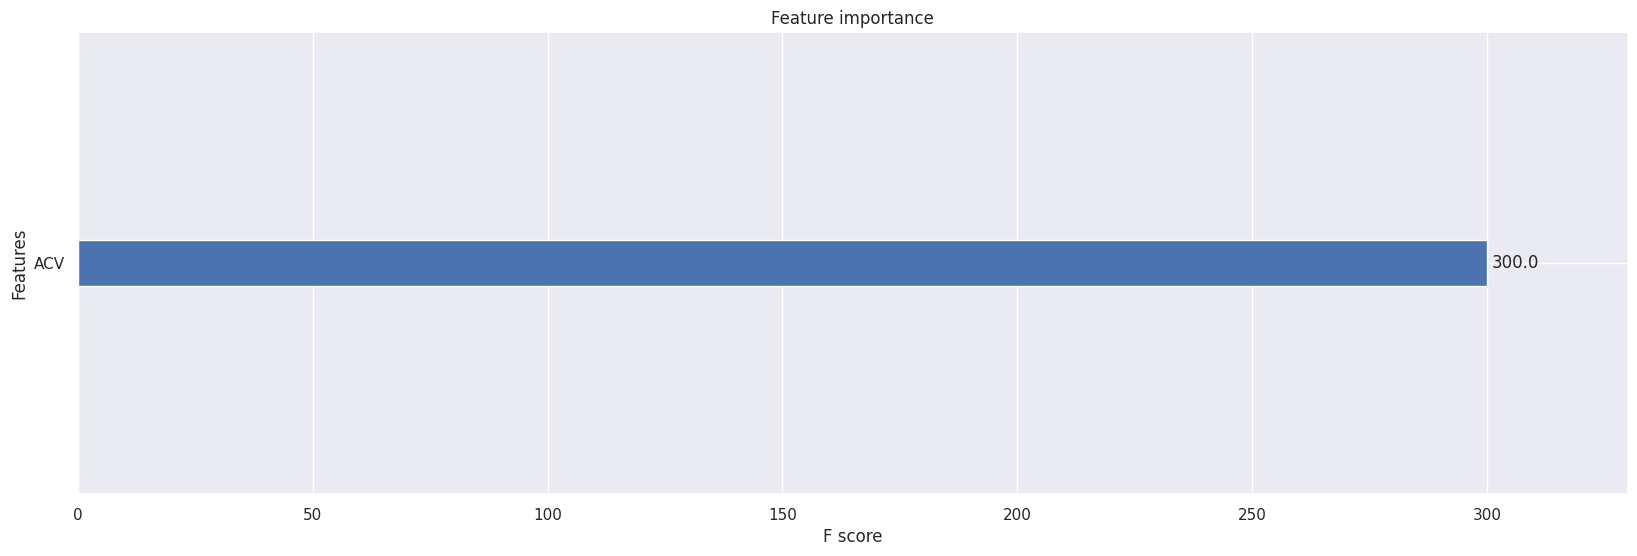

In [ ]:
from xgboost import plot_importance
ax = plot_importance(optimized_xgb_clf, max_num_features=10)
ax.figure.set_size_inches(20, 6)
ax.figure.savefig('./ActuarialThesis/plots_clf/myXGBoostClassifierFeatureImportances.pdf')

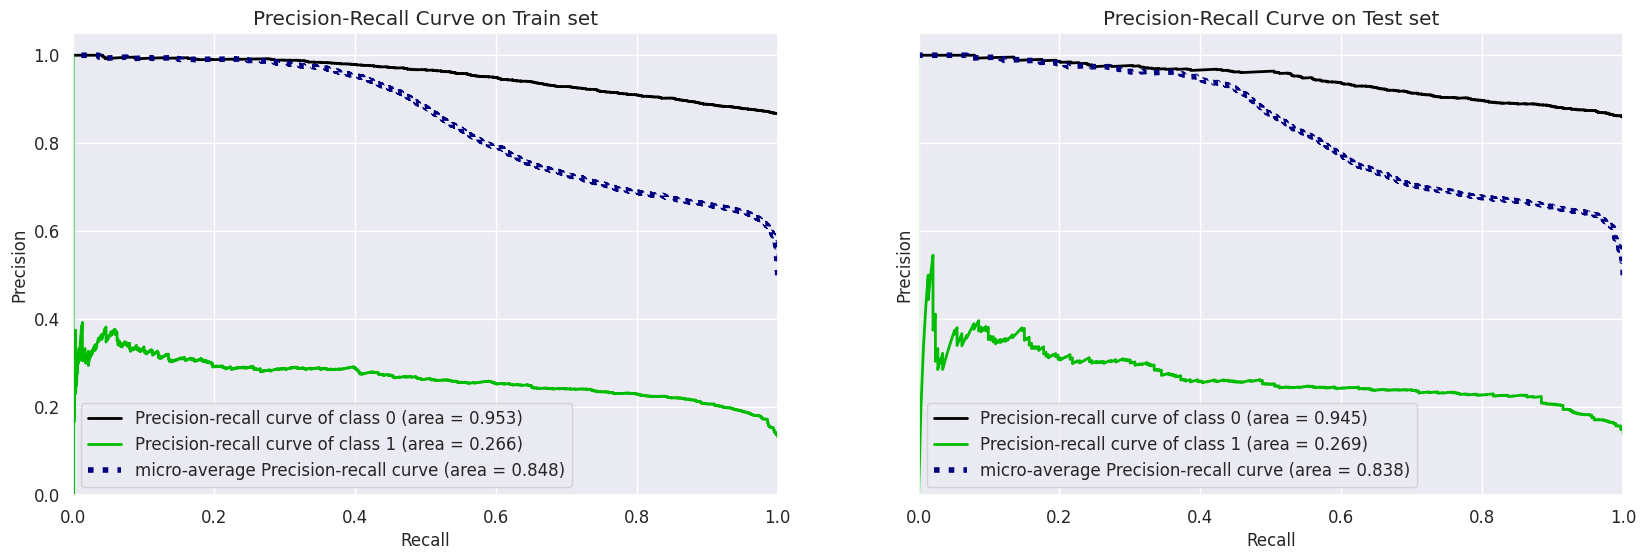

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(18, 6))
y_probas = optimized_xgb_clf.predict_proba(X_train)
skplt.metrics.plot_precision_recall(y_train, y_probas, ax = ax1, title = 'Precision-Recall Curve on Train set')

y_probas = optimized_xgb_clf.predict_proba(X_test)
skplt.metrics.plot_precision_recall(y_test, y_probas, ax = ax2, title = 'Precision-Recall Curve on Test set')

fig.set_size_inches(20, 6)
fig.savefig('./ActuarialThesis/plots_clf/myCatBoostClassifierPrecisionRecallCurve.pdf', bbox_inches='tight')
plt.show();

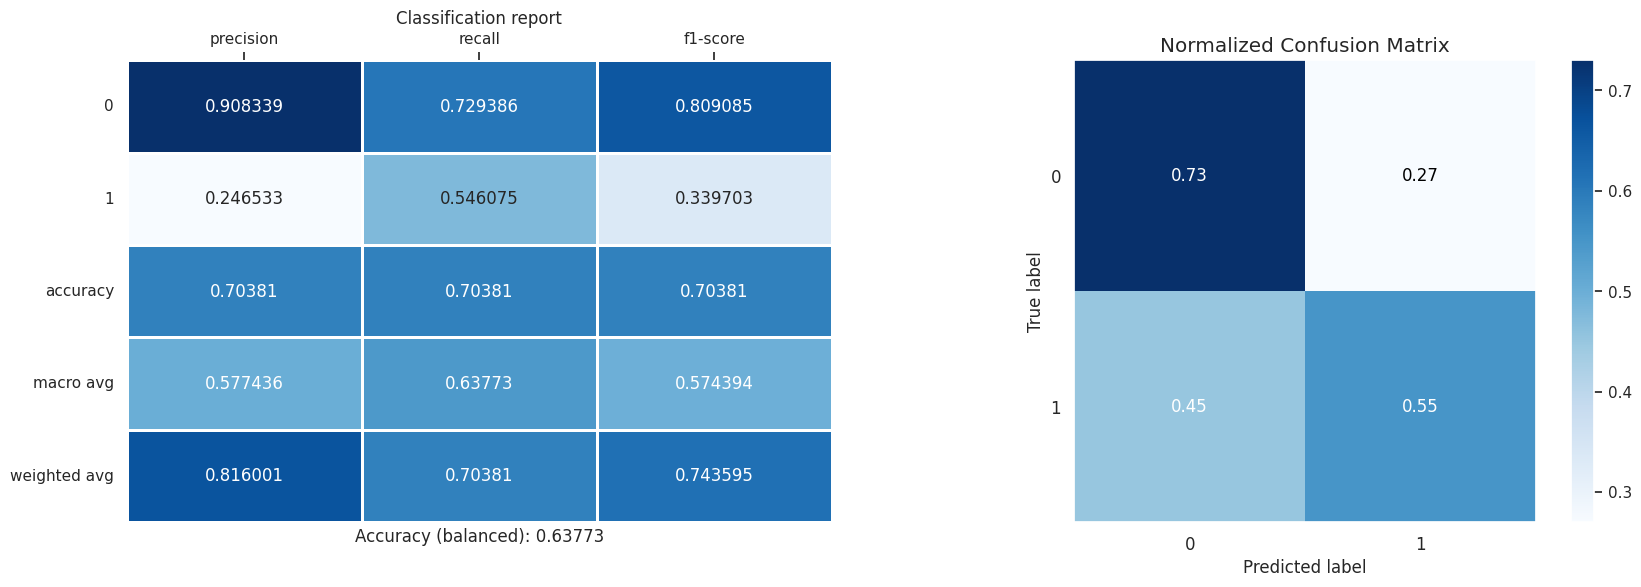

In [ ]:
fig = plot_classification_report_confusion_matrix(optimized_xgb_clf, X_test, y_test)
fig.set_size_inches(20, 6)
fig.savefig('./ActuarialThesis/plots_clf/myXGBoostClassifierConfusionMatrix.pdf', bbox_inches='tight')

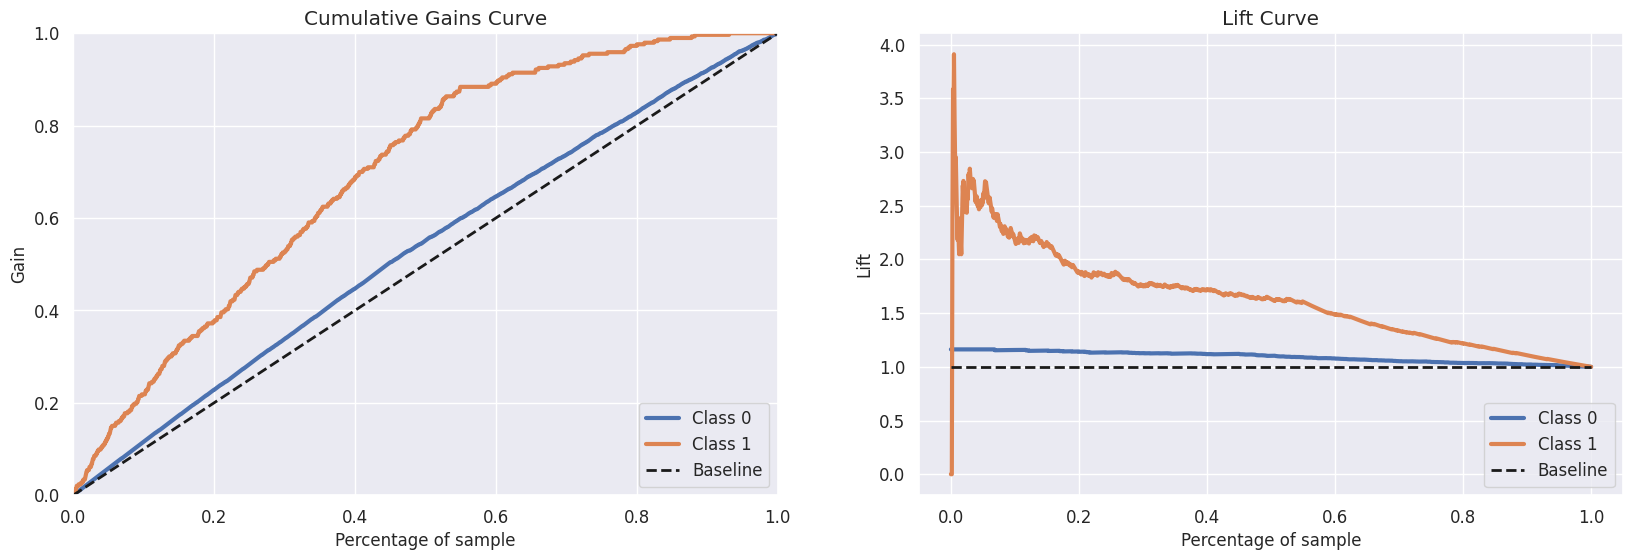

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
y_probas = optimized_xgb_clf.predict_proba(X_test)
skplt.metrics.plot_cumulative_gain(y_test, y_probas, ax = ax1)
skplt.metrics.plot_lift_curve(y_test, y_probas, ax = ax2)
fig.set_size_inches(20, 6)
fig.savefig('./ActuarialThesis/plots_clf/myXGBoost_cumulative_gain_lift_curve.pdf', bbox_inches='tight')
plt.show();